In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
# Read Data

training_data_df = pd.read_csv('./prepped_data/training_data_ver_5.csv')
print(training_data_df.shape)
training_data_df.head()

(3569918, 32)


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가(만원),표준지여부,지목코드,토지면적_log,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,year_linear,month_sin,month_cos,x_norm,y_norm,x_2nd,y_2nd,x*y,x_sin,y_sin,x_cos,y_cos
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,921.0,0,8,7.063305,15,0,2,3,3,7.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,921.0,0,8,7.063305,15,0,2,3,3,7.916667,-0.500000,0.866025,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,450.160772,4,25,10.463103,6.109605,1,921.0,0,8,7.063305,15,0,2,3,3,7.000000,0.000000,1.000000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,411.575563,9,25,10.373491,6.019993,1,921.0,0,8,7.063305,15,0,2,3,3,7.166667,0.866025,0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,475.884244,1,25,10.518673,6.165175,1,921.0,0,8,7.063305,15,0,2,3,3,7.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138


In [3]:
cat_cols = ['trade_type', '특수지구분명', '표준지여부', '지목코드', '용도지역코드1', '용도지역코드2', '지형높이코드',
            '지형형상코드', '도로접면코드'
           ]

In [5]:
test_data = training_data_df.drop(columns=['지번주소', '도로명주소']).sample(frac=0.2)
train_data = training_data_df.drop(columns=['지번주소', '도로명주소']).drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(713984, 30)
(571187, 30)
(2284747, 30)


In [6]:
target_cols = ['금액(만원)', '가격/면적', 'target_log_transformed', 'target/area_log_transformed']#, 'land_area_log']

In [17]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['target/area_log_transformed']
print(x_test.shape)
print(y_test.shape)

(713984, 26)
(713984,)


In [18]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['target/area_log_transformed']
print(x_valid.shape)
print(y_valid.shape)

(571187, 26)
(571187,)


In [19]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['target/area_log_transformed']
print(x_train.shape)
print(y_train.shape)

(2284747, 26)
(2284747,)


<AxesSubplot:>

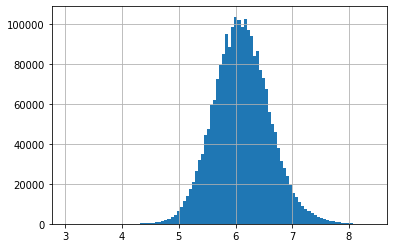

In [20]:
y_train.hist(bins=100)

# Training

In [11]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [12]:
import lightgbm as lgb

In [13]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse'
}

In [14]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [15]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3453
[LightGBM] [Info] Number of data points in the train set: 2284747, number of used features: 26


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 509.789259
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 151.171
[100]	valid_0's rmse: 123.549
[150]	valid_0's rmse: 112.028
[200]	valid_0's rmse: 105.693
[250]	valid_0's rmse: 101.642
[300]	valid_0's rmse: 98.7079
[350]	valid_0's rmse: 96.3492
[400]	valid_0's rmse: 94.3494
[450]	valid_0's rmse: 92.6763
[500]	valid_0's rmse: 91.2463
[550]	valid_0's rmse: 90.0804
[600]	valid_0's rmse: 89.0072
[650]	valid_0's rmse: 88.0486
[700]	valid_0's rmse: 87.166
[750]	valid_0's rmse: 86.3636
[800]	valid_0's rmse: 85.6296
[850]	valid_0's rmse: 84.954
[900]	valid_0's rmse: 84.2965
[950]	valid_0's rmse: 83.7158
[1000]	valid_0's rmse: 83.1632
[1050]	valid_0's rmse: 82.5684
[1100]	valid_0's rmse: 82.0308
[1150]	valid_0's rmse: 81.532
[1200]	valid_0's rmse: 81.0539
[1250]	valid_0's rmse: 80.5911
[1300]	valid_0's rmse: 80.1784
[1350]	valid_0's rmse: 79.7163
[1400]	valid_0's rmse: 79.3147
[1450]	valid_0's rmse: 78.9288
[1500]	

[13100]	valid_0's rmse: 60.0973
[13150]	valid_0's rmse: 60.0724
[13200]	valid_0's rmse: 60.0477
[13250]	valid_0's rmse: 60.0277
[13300]	valid_0's rmse: 60.0014
[13350]	valid_0's rmse: 59.9809
[13400]	valid_0's rmse: 59.9547
[13450]	valid_0's rmse: 59.9291
[13500]	valid_0's rmse: 59.9094
[13550]	valid_0's rmse: 59.8871
[13600]	valid_0's rmse: 59.8664
[13650]	valid_0's rmse: 59.8477
[13700]	valid_0's rmse: 59.828
[13750]	valid_0's rmse: 59.806
[13800]	valid_0's rmse: 59.7815
[13850]	valid_0's rmse: 59.7629
[13900]	valid_0's rmse: 59.7392
[13950]	valid_0's rmse: 59.7165
[14000]	valid_0's rmse: 59.6979
[14050]	valid_0's rmse: 59.6786
[14100]	valid_0's rmse: 59.6551
[14150]	valid_0's rmse: 59.6327
[14200]	valid_0's rmse: 59.6111
[14250]	valid_0's rmse: 59.5894
[14300]	valid_0's rmse: 59.5674
[14350]	valid_0's rmse: 59.5474
[14400]	valid_0's rmse: 59.5261
[14450]	valid_0's rmse: 59.5083
[14500]	valid_0's rmse: 59.485
[14550]	valid_0's rmse: 59.4673
[14600]	valid_0's rmse: 59.4458
[14650]	val

[25950]	valid_0's rmse: 56.3713
[26000]	valid_0's rmse: 56.3614
[26050]	valid_0's rmse: 56.351
[26100]	valid_0's rmse: 56.3419
[26150]	valid_0's rmse: 56.3321
[26200]	valid_0's rmse: 56.3213
[26250]	valid_0's rmse: 56.313
[26300]	valid_0's rmse: 56.3047
[26350]	valid_0's rmse: 56.295
[26400]	valid_0's rmse: 56.2876
[26450]	valid_0's rmse: 56.2775
[26500]	valid_0's rmse: 56.2695
[26550]	valid_0's rmse: 56.2608
[26600]	valid_0's rmse: 56.2516
[26650]	valid_0's rmse: 56.2424
[26700]	valid_0's rmse: 56.2341
[26750]	valid_0's rmse: 56.2247
[26800]	valid_0's rmse: 56.2159
[26850]	valid_0's rmse: 56.2086
[26900]	valid_0's rmse: 56.2003
[26950]	valid_0's rmse: 56.1906
[27000]	valid_0's rmse: 56.182
[27050]	valid_0's rmse: 56.1725
[27100]	valid_0's rmse: 56.1643
[27150]	valid_0's rmse: 56.1552
[27200]	valid_0's rmse: 56.1461
[27250]	valid_0's rmse: 56.1371
[27300]	valid_0's rmse: 56.1297
[27350]	valid_0's rmse: 56.1229
[27400]	valid_0's rmse: 56.1162
[27450]	valid_0's rmse: 56.1074
[27500]	vali

[38800]	valid_0's rmse: 54.6292
[38850]	valid_0's rmse: 54.624
[38900]	valid_0's rmse: 54.6197
[38950]	valid_0's rmse: 54.6144
[39000]	valid_0's rmse: 54.6094
[39050]	valid_0's rmse: 54.6044
[39100]	valid_0's rmse: 54.5976
[39150]	valid_0's rmse: 54.5936
[39200]	valid_0's rmse: 54.589
[39250]	valid_0's rmse: 54.5845
[39300]	valid_0's rmse: 54.5797
[39350]	valid_0's rmse: 54.5754
[39400]	valid_0's rmse: 54.5715
[39450]	valid_0's rmse: 54.568
[39500]	valid_0's rmse: 54.5631
[39550]	valid_0's rmse: 54.5589
[39600]	valid_0's rmse: 54.5533
[39650]	valid_0's rmse: 54.5482
[39700]	valid_0's rmse: 54.5451
[39750]	valid_0's rmse: 54.5401
[39800]	valid_0's rmse: 54.5349
[39850]	valid_0's rmse: 54.5291
[39900]	valid_0's rmse: 54.5242
[39950]	valid_0's rmse: 54.5184
[40000]	valid_0's rmse: 54.5142
[40050]	valid_0's rmse: 54.5085
[40100]	valid_0's rmse: 54.5044
[40150]	valid_0's rmse: 54.4983
[40200]	valid_0's rmse: 54.4942
[40250]	valid_0's rmse: 54.4891
[40300]	valid_0's rmse: 54.4847
[40350]	val

[51650]	valid_0's rmse: 53.5851
[51700]	valid_0's rmse: 53.5813
[51750]	valid_0's rmse: 53.5778
[51800]	valid_0's rmse: 53.5751
[51850]	valid_0's rmse: 53.5716
[51900]	valid_0's rmse: 53.5689
[51950]	valid_0's rmse: 53.5662
[52000]	valid_0's rmse: 53.5624
[52050]	valid_0's rmse: 53.5584
[52100]	valid_0's rmse: 53.5554
[52150]	valid_0's rmse: 53.5525
[52200]	valid_0's rmse: 53.5495
[52250]	valid_0's rmse: 53.5467
[52300]	valid_0's rmse: 53.5437
[52350]	valid_0's rmse: 53.5402
[52400]	valid_0's rmse: 53.5372
[52450]	valid_0's rmse: 53.5341
[52500]	valid_0's rmse: 53.5304
[52550]	valid_0's rmse: 53.5269
[52600]	valid_0's rmse: 53.5239
[52650]	valid_0's rmse: 53.5206
[52700]	valid_0's rmse: 53.5165
[52750]	valid_0's rmse: 53.5137
[52800]	valid_0's rmse: 53.5101
[52850]	valid_0's rmse: 53.5066
[52900]	valid_0's rmse: 53.5035
[52950]	valid_0's rmse: 53.5009
[53000]	valid_0's rmse: 53.498
[53050]	valid_0's rmse: 53.4947
[53100]	valid_0's rmse: 53.4905
[53150]	valid_0's rmse: 53.4862
[53200]	v

[64500]	valid_0's rmse: 52.91
[64550]	valid_0's rmse: 52.9079
[64600]	valid_0's rmse: 52.9054
[64650]	valid_0's rmse: 52.9027
[64700]	valid_0's rmse: 52.9005
[64750]	valid_0's rmse: 52.8982
[64800]	valid_0's rmse: 52.8964
[64850]	valid_0's rmse: 52.894
[64900]	valid_0's rmse: 52.8908
[64950]	valid_0's rmse: 52.8886
[65000]	valid_0's rmse: 52.8864
[65050]	valid_0's rmse: 52.8841
[65100]	valid_0's rmse: 52.8822
[65150]	valid_0's rmse: 52.8796
[65200]	valid_0's rmse: 52.8777
[65250]	valid_0's rmse: 52.8757
[65300]	valid_0's rmse: 52.8741
[65350]	valid_0's rmse: 52.8724
[65400]	valid_0's rmse: 52.8704
[65450]	valid_0's rmse: 52.8682
[65500]	valid_0's rmse: 52.8664
[65550]	valid_0's rmse: 52.8645
[65600]	valid_0's rmse: 52.8626
[65650]	valid_0's rmse: 52.8607
[65700]	valid_0's rmse: 52.8588
[65750]	valid_0's rmse: 52.856
[65800]	valid_0's rmse: 52.8539
[65850]	valid_0's rmse: 52.8511
[65900]	valid_0's rmse: 52.8483
[65950]	valid_0's rmse: 52.8462
[66000]	valid_0's rmse: 52.8444
[66050]	vali

[77350]	valid_0's rmse: 52.4232
[77400]	valid_0's rmse: 52.421
[77450]	valid_0's rmse: 52.4201
[77500]	valid_0's rmse: 52.4185
[77550]	valid_0's rmse: 52.4168
[77600]	valid_0's rmse: 52.4151
[77650]	valid_0's rmse: 52.4127
[77700]	valid_0's rmse: 52.4114
[77750]	valid_0's rmse: 52.4105
[77800]	valid_0's rmse: 52.4089
[77850]	valid_0's rmse: 52.4071
[77900]	valid_0's rmse: 52.4054
[77950]	valid_0's rmse: 52.4042
[78000]	valid_0's rmse: 52.4024
[78050]	valid_0's rmse: 52.4009
[78100]	valid_0's rmse: 52.4001
[78150]	valid_0's rmse: 52.3986
[78200]	valid_0's rmse: 52.397
[78250]	valid_0's rmse: 52.3956
[78300]	valid_0's rmse: 52.3944
[78350]	valid_0's rmse: 52.393
[78400]	valid_0's rmse: 52.3908
[78450]	valid_0's rmse: 52.3893
[78500]	valid_0's rmse: 52.3879
[78550]	valid_0's rmse: 52.3863
[78600]	valid_0's rmse: 52.3848
[78650]	valid_0's rmse: 52.3831
[78700]	valid_0's rmse: 52.3812
[78750]	valid_0's rmse: 52.3795
[78800]	valid_0's rmse: 52.3784
[78850]	valid_0's rmse: 52.3771
[78900]	val

[90200]	valid_0's rmse: 52.0825
[90250]	valid_0's rmse: 52.0804
[90300]	valid_0's rmse: 52.0794
[90350]	valid_0's rmse: 52.0784
[90400]	valid_0's rmse: 52.0772
[90450]	valid_0's rmse: 52.076
[90500]	valid_0's rmse: 52.0747
[90550]	valid_0's rmse: 52.0737
[90600]	valid_0's rmse: 52.073
[90650]	valid_0's rmse: 52.0714
[90700]	valid_0's rmse: 52.0704
[90750]	valid_0's rmse: 52.0695
[90800]	valid_0's rmse: 52.0683
[90850]	valid_0's rmse: 52.0674
[90900]	valid_0's rmse: 52.0665
[90950]	valid_0's rmse: 52.0651
[91000]	valid_0's rmse: 52.0641
[91050]	valid_0's rmse: 52.0631
[91100]	valid_0's rmse: 52.0616
[91150]	valid_0's rmse: 52.0605
[91200]	valid_0's rmse: 52.0595
[91250]	valid_0's rmse: 52.0581
[91300]	valid_0's rmse: 52.0568
[91350]	valid_0's rmse: 52.0559
[91400]	valid_0's rmse: 52.0548
[91450]	valid_0's rmse: 52.0538
[91500]	valid_0's rmse: 52.0518
[91550]	valid_0's rmse: 52.05
[91600]	valid_0's rmse: 52.049
[91650]	valid_0's rmse: 52.0478
[91700]	valid_0's rmse: 52.0463
[91750]	valid

[103000]	valid_0's rmse: 51.8091
[103050]	valid_0's rmse: 51.8079
[103100]	valid_0's rmse: 51.8068
[103150]	valid_0's rmse: 51.8058
[103200]	valid_0's rmse: 51.8044
[103250]	valid_0's rmse: 51.8035
[103300]	valid_0's rmse: 51.8026
[103350]	valid_0's rmse: 51.8021
[103400]	valid_0's rmse: 51.8012
[103450]	valid_0's rmse: 51.8005
[103500]	valid_0's rmse: 51.7995
[103550]	valid_0's rmse: 51.7986
[103600]	valid_0's rmse: 51.7977
[103650]	valid_0's rmse: 51.7965
[103700]	valid_0's rmse: 51.7953
[103750]	valid_0's rmse: 51.7946
[103800]	valid_0's rmse: 51.7942
[103850]	valid_0's rmse: 51.7933
[103900]	valid_0's rmse: 51.7925
[103950]	valid_0's rmse: 51.7918
[104000]	valid_0's rmse: 51.7906
[104050]	valid_0's rmse: 51.7898
[104100]	valid_0's rmse: 51.7884
[104150]	valid_0's rmse: 51.7875
[104200]	valid_0's rmse: 51.7866
[104250]	valid_0's rmse: 51.7863
[104300]	valid_0's rmse: 51.7851
[104350]	valid_0's rmse: 51.7843
[104400]	valid_0's rmse: 51.7833
[104450]	valid_0's rmse: 51.7823
[104500]	v

[115450]	valid_0's rmse: 51.6069
[115500]	valid_0's rmse: 51.6062
[115550]	valid_0's rmse: 51.6055
[115600]	valid_0's rmse: 51.6044
[115650]	valid_0's rmse: 51.6036
[115700]	valid_0's rmse: 51.6031
[115750]	valid_0's rmse: 51.6026
[115800]	valid_0's rmse: 51.6018
[115850]	valid_0's rmse: 51.601
[115900]	valid_0's rmse: 51.5999
[115950]	valid_0's rmse: 51.5991
[116000]	valid_0's rmse: 51.5983
[116050]	valid_0's rmse: 51.5978
[116100]	valid_0's rmse: 51.5975
[116150]	valid_0's rmse: 51.5969
[116200]	valid_0's rmse: 51.5961
[116250]	valid_0's rmse: 51.5952
[116300]	valid_0's rmse: 51.5944
[116350]	valid_0's rmse: 51.594
[116400]	valid_0's rmse: 51.5936
[116450]	valid_0's rmse: 51.5929
[116500]	valid_0's rmse: 51.5923
[116550]	valid_0's rmse: 51.5918
[116600]	valid_0's rmse: 51.5913
[116650]	valid_0's rmse: 51.5906
[116700]	valid_0's rmse: 51.5902
[116750]	valid_0's rmse: 51.5899
[116800]	valid_0's rmse: 51.5896
[116850]	valid_0's rmse: 51.5889
[116900]	valid_0's rmse: 51.5881
[116950]	val

[127950]	valid_0's rmse: 51.4498
[128000]	valid_0's rmse: 51.4494
[128050]	valid_0's rmse: 51.4489
[128100]	valid_0's rmse: 51.4485
[128150]	valid_0's rmse: 51.448
[128200]	valid_0's rmse: 51.4475
[128250]	valid_0's rmse: 51.4468
[128300]	valid_0's rmse: 51.4459
[128350]	valid_0's rmse: 51.4456
[128400]	valid_0's rmse: 51.4456
[128450]	valid_0's rmse: 51.4452
[128500]	valid_0's rmse: 51.4445
[128550]	valid_0's rmse: 51.4441
[128600]	valid_0's rmse: 51.4434
[128650]	valid_0's rmse: 51.4429
[128700]	valid_0's rmse: 51.4425
[128750]	valid_0's rmse: 51.4421
[128800]	valid_0's rmse: 51.4415
[128850]	valid_0's rmse: 51.4413
[128900]	valid_0's rmse: 51.4406
[128950]	valid_0's rmse: 51.44
[129000]	valid_0's rmse: 51.4394
[129050]	valid_0's rmse: 51.4386
[129100]	valid_0's rmse: 51.4384
[129150]	valid_0's rmse: 51.4377
[129200]	valid_0's rmse: 51.4369
[129250]	valid_0's rmse: 51.4362
[129300]	valid_0's rmse: 51.4355
[129350]	valid_0's rmse: 51.4348
[129400]	valid_0's rmse: 51.4341
[129450]	vali

[140450]	valid_0's rmse: 51.3266
[140500]	valid_0's rmse: 51.3262
[140550]	valid_0's rmse: 51.3258
[140600]	valid_0's rmse: 51.3255
[140650]	valid_0's rmse: 51.3249
[140700]	valid_0's rmse: 51.3244
[140750]	valid_0's rmse: 51.3237
[140800]	valid_0's rmse: 51.3233
[140850]	valid_0's rmse: 51.3229
[140900]	valid_0's rmse: 51.3222
[140950]	valid_0's rmse: 51.3221
[141000]	valid_0's rmse: 51.3215
[141050]	valid_0's rmse: 51.321
[141100]	valid_0's rmse: 51.3207
[141150]	valid_0's rmse: 51.32
[141200]	valid_0's rmse: 51.3195
[141250]	valid_0's rmse: 51.3188
[141300]	valid_0's rmse: 51.3182
[141350]	valid_0's rmse: 51.3177
[141400]	valid_0's rmse: 51.3173
[141450]	valid_0's rmse: 51.3167
[141500]	valid_0's rmse: 51.3159
[141550]	valid_0's rmse: 51.3155
[141600]	valid_0's rmse: 51.3143
[141650]	valid_0's rmse: 51.3139
[141700]	valid_0's rmse: 51.3135
[141750]	valid_0's rmse: 51.3126
[141800]	valid_0's rmse: 51.3123
[141850]	valid_0's rmse: 51.3117
[141900]	valid_0's rmse: 51.3111
[141950]	vali

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\max6296\ml\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s

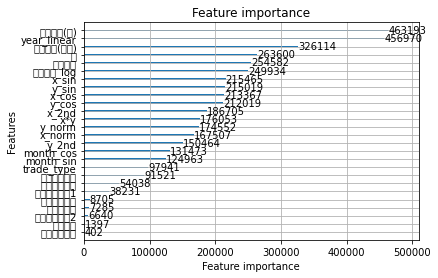

In [16]:
lgb.plot_importance(bst)

In [ ]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_2021_01_03_22_11.csv', index=False)

In [ ]:
pd.DataFrame({'pred':pred}).to_csv('lgb_pred_2021_01_03_22_12.csv', index=False)

In [ ]:
r2_score(y_test, pred)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'pred':pred})
print(compare_df.shape)
compare_df.head()

In [ ]:
compare_df.tail()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols_mapped)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols_mapped)
test_pool = Pool(x_test, y_test, cat_features=cat_cols_mapped)

In [ ]:
model = CatBoostRegressor(task_type='GPU', iterations=100000, learning_rate=0.1)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)